This notebook contains the machine learning model of *Decision Trees*. Decision trees are a fundamental model to lead because they learn to the ensemble models of *Bagging*, *Random Forests*, *Boosting*, etc. 

They are simple and useful for interpretation, but are **not competitive** with the best supervised learning approaches in terms of *prediction accuracy*. Nevertheless, interpretation is useful in the context of hospital charges as they provide a clear visualization of how decisions are made, showing exactly which features and what conditions or thresholds lead to specific conditions. 

We will utilize *tree pruning* with cost complexity pruning to help deal with overfitting. However, this will likely still lead to subpar predictive power. 


Our target metric is *Root Mean Squared Error* (RMSE). Our best Linear Regression Model was Lasso Regression which achieved a rather underwhelming RMSE of \\$63,477. This was not unexpected as the data failed the assumptions of Linear Regression and we expect the data to be more complicated.

**GOAL:** Low RMSE on the test set

In [46]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, make_scorer

from sklearn.tree import DecisionTreeRegressor, plot_tree

import matplotlib.pyplot as plt


In [17]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better = False) 

In [ ]:
# Set pandas display precision to 4 decimal places
pd.options.display.float_format = '{:.4f}'.format
np.set_printoptions(precision=4)

# Importing Dataset

In [60]:
# Importing processed dataframe
path_project = "C:/Users/Conno/Documents/Career/Projects/Hospital_Charges/tree_based_models"

os.chdir(path_project)
plots_dir = 'decision_tree_plots' # stores plots in plot folder

df = pd.read_csv("../df_processed.csv")

# do this later in data_cleaning file
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

df.dtypes

age                           float64
death                           int64
hospdead                        int64
slos                            int64
d_time                          int64
edu                           float64
scoma                         float64
charges                       float64
avtisst                       float64
sps                           float64
aps                           float64
surv2m                        float64
surv6m                        float64
hday                            int64
diabetes                        int64
dementia                        int64
prg2m                         float64
prg6m                         float64
dnrday                        float64
meanbp                        float64
wblc                          float64
hrt                           float64
resp                          float64
temp                          float64
crea                          float64
sod                           float64
adlsc       

## Train-Test Split

In [7]:
X = df.drop(columns = ["charges"])
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 32)

# Random Tree

Regression trees use a *recursive binary splitting* approach. The approach is top-down because it begins at the top of the tree then successively splits the predictor space; each split is indicated via *two* new branches further down the tree.

In order to perform recursive binary splitting we first select the predictor $X_j$ and the cutpoint $s$ such that the splitting the predictor space into the regions $\{X|X_j < s\}$ and $\{ X|X_j \ge s \}$ leads to the *greatest possible reduction* in *RSS*


## Full Tree

In [53]:
# defining the model from sklearn
tree_regressor = DecisionTreeRegressor(random_state=32)

# train the model on the entire training set
tree_regressor.fit(X_train, y_train)

# use the trained model to predict on the test set
y_pred = tree_regressor.predict(X_test)

# calculate RMSE for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

print("5 Fold Cross Validation Train RMSE:", round(np.mean(np.abs(cross_val_score(tree_regressor, X_train, y_train, scoring=rmse_scorer, cv=5))), 4))
print("Test RMSE:", round(rmse_test, 4))


5 Fold Cross Validation Train RMSE: 82133.4506
Test RMSE: 80968.3869


This RMSE is worse than any of our linear models. This is expected, however, because decision trees in general have low predictive power. This is because they are very prone to overfitting. Decision trees have *high variance* and *low bias*. In our case the test set performed better which doesn't necessarily indicate overfitting but it still performed poorly. We will will then perform *tree pruning*.

## Tree Pruning

*Cost Complexity Pruning* is similar to lasso and ridge regularization (adding a penalty for complexity to model evaluation). The complexity (regularization) parameter $\alpha$ is the pruning parameter.

$$R_{\alpha}(T) = R(T) + \alpha|\bar{T}|$$

$R(T)$ is the total impurity of the terminal nodes and  $|\bar{T}|$ is the number of terminal nodes

In [54]:
# generate cost complexity pruning path. The path represents the sequence of trees obtained by applying different values of 
# ccp_alpha ranging from 0 (tree is fully grown) to a maximum value where the t ree would be pruned down to just the root node.

path = tree_regressor.cost_complexity_pruning_path(X_train, y_train) # a series of decision trees coressponding to a different value
# of ccp_alpha
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [55]:
# train decision trees across the pruning path

tree_regressor_prunes = []
for ccp_alpha in ccp_alphas:
    tree_regressor = DecisionTreeRegressor(random_state = 32, ccp_alpha = ccp_alpha)
    tree_regressor.fit(X_train, y_train)
    tree_regressor_prunes.append(tree_regressor)
    
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        tree_regressor_prunes[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 2496042013.880451


In [56]:
print(len(ccp_alphas), len(tree_regressor_prunes))


3709 3709


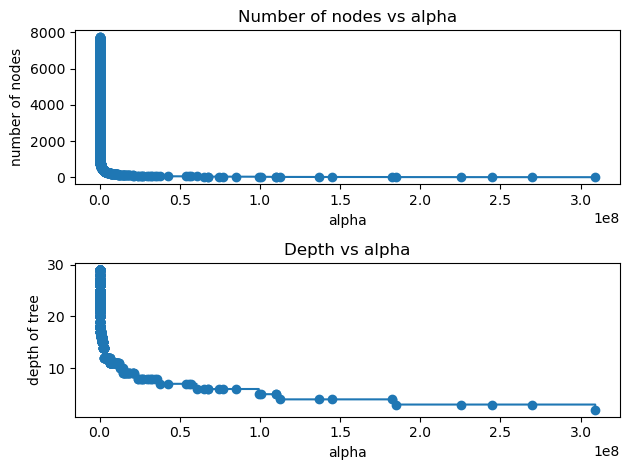

In [61]:
tree_regressor_prunes = tree_regressor_prunes[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [tree_regressor.tree_.node_count for tree_regressor in tree_regressor_prunes]
depth = [tree_regressor.tree_.max_depth for tree_regressor in tree_regressor_prunes]

fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")

alpha_nodes_depth_plot = os.path.join(plots_dir, 'alpha_nodes_depth_plot')
fig.savefig(alpha_nodes_depth_plot)
fig.tight_layout()

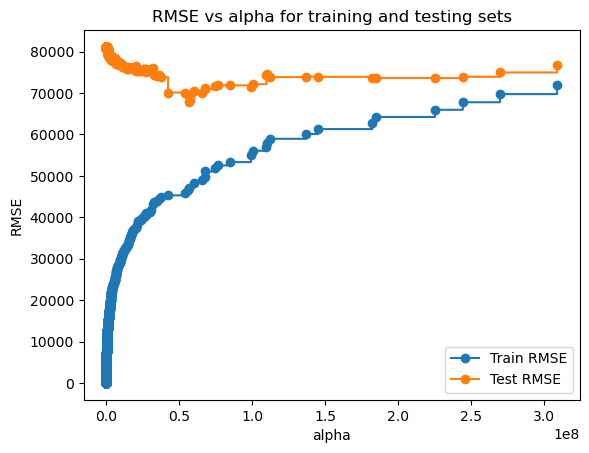

In [62]:
train_rmse = [rmse(y_train, tree.predict(X_train)) for tree in tree_regressor_prunes]
test_rmse = [rmse(y_test, tree.predict(X_test)) for tree in tree_regressor_prunes]


fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("RMSE")
ax.set_title("RMSE vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_rmse, marker="o", label="Train RMSE", drawstyle="steps-post")
ax.plot(ccp_alphas, test_rmse, marker="o", label="Test RMSE", drawstyle="steps-post")
ax.legend()

alpha_train_test_plot = os.path.join(plots_dir, 'alpha_train_test_plot')
fig.savefig(alpha_train_test_plot)

plt.show()

In [64]:
min_rmse_index = np.argmin(test_rmse) # finds tree with minimum RMSE (np.argmin finds index)

best_tree = tree_regressor_prunes[min_rmse_index]

best_ccp_alpha = ccp_alphas[min_rmse_index]
best_node_count = best_tree.tree_.node_count
best_depth = best_tree.tree_.max_depth

print("Lowest Test RMSE:", test_rmse[min_rmse_index])
print("Best ccp_alpha:", best_ccp_alpha)
print("Number of nodes in the best tree:", best_node_count)
print("Depth of the best tree:", best_depth)

Lowest Test RMSE: 67853.61023265356
Best ccp_alpha: 56895274.700834036
Number of nodes in the best tree: 53
Depth of the best tree: 7


The test RMSE is still lower than those of the linear regression models. Again, this was expected. Decision trees lead to *Bagging* which decreases variance by bootstrapping and then *Random Forests*

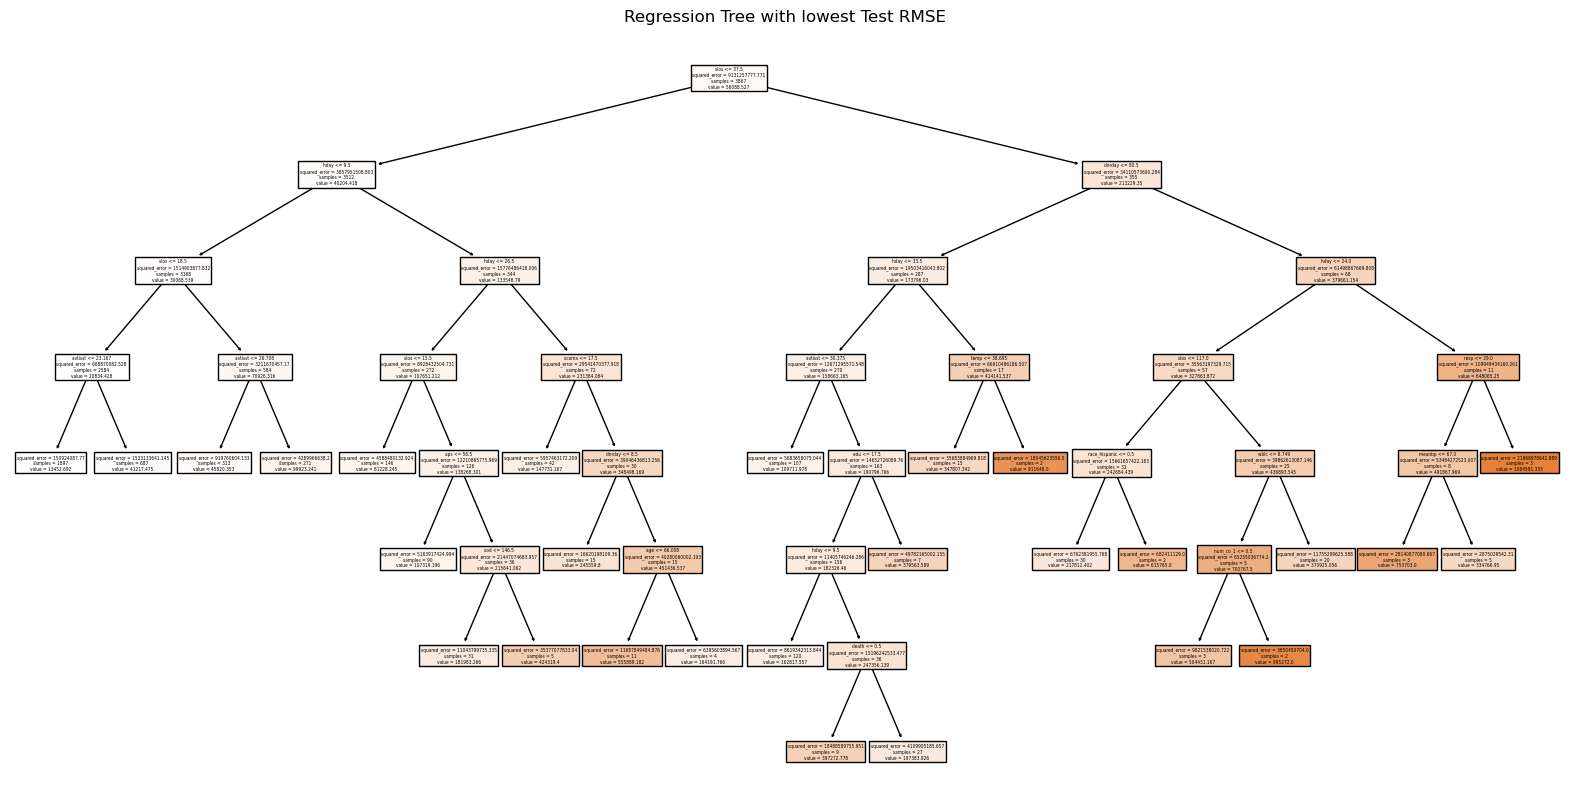

In [68]:
fig, ax = plt.subplots(figsize=(20, 10)) 
plot_tree(best_tree, filled=True, feature_names=X_train.columns, ax=ax)
ax.set_title("Regression Tree with lowest Test RMSE")

best_pruned_tree_plot = os.path.join(plots_dir, 'best_pruned_tree_plot')
fig.savefig(best_pruned_tree_plot, dpi = 300)
plt.show()

**Darker Nodes** indicate higher average hospital charges

**Lighter Nodes** indicate lower average hospital charges